<a href="https://colab.research.google.com/github/maxploter/ML/blob/main/course-ml-voron/MachineLearningSeminars_results/sem2/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
sem_num = '2'
project_name = 'course-ml-voron/MachineLearningSeminars'

own_project_notebook_path = f'{project_name}_results/sem{sem_num}/'
print(own_project_notebook_path)

course-ml-voron/MachineLearningSeminars_results/sem2/


# Линейные методы классификации и регрессии: метод стохастического градиента

## Библиотеки

In [2]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !wget -q -O requirements.txt https://raw.githubusercontent.com/andriygav/MachineLearningSeminars/master/sem2/requirements.txt
    !pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 50.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.special import expit
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import torch

from sklearn.linear_model import (LogisticRegression,
                                  LinearRegression)
from sklearn.model_selection import LeaveOneOut, KFold

## Разбор домашней задачи

In [4]:
# Генерация данных
np.random.seed(0)
l = 100
n = 2
X1 = np.array([[-1,-1]]) + 0.5*np.random.randn(l, n)
X2 = np.array([[1,1]]) + 0.5*np.random.randn(l, n)
X3 = np.array([[-1,1]]) + 0.5*np.random.randn(l, n)

X = np.vstack([X1, X2, X3])
y = np.hstack([[0]*l, [1]*l, [2]*l])

# Добавляем константу
X = np.hstack([X, np.ones([len(X), 1])])

In [5]:
# обучения моделей
models = []
model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==0, dtype=np.int64))
models.append(model)

model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==1, dtype=np.int64))
models.append(model)

model = LogisticRegression(random_state=0, max_iter=2000, fit_intercept=False)
_ = model.fit(X, np.array(y==2, dtype=np.int64))
models.append(model)

In [6]:
def get_line(a, b, c=0, x_min=-10, x_max=10):
    x1, y1 = -(-b + c)/a, -1
    x2, y2 = -(b + c)/a, 1

    polynomial = np.poly1d(np.polyfit([x1, x2], [y1, y2], 1))
    x_axis = np.linspace(x_min, x_max)
    y_axis = polynomial(x_axis)

    return x_axis, y_axis

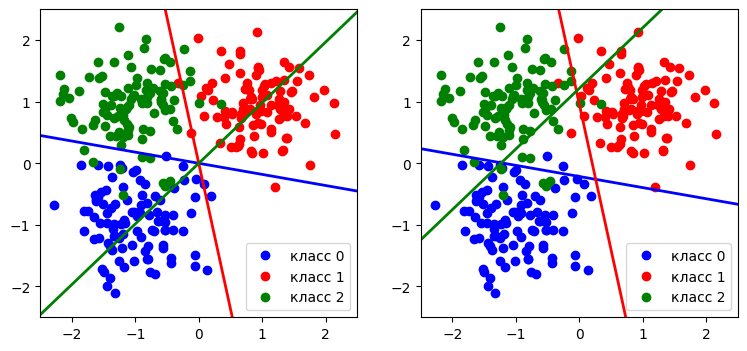

In [7]:
cols = ['blue', 'red', 'green']
fig, gs = plt.figure(figsize=(9,4)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].set_xlim((-2.5, 2.5)), ax[i].set_ylim((-2.5, 2.5))

for k in np.unique(y):
    ax[0].plot(X[y==k,0], X[y==k,1], 'o',
               label='класс {}'.format(k), color=cols[k])
    ax[1].plot(X[y==k,0], X[y==k,1], 'o',
               label='класс {}'.format(k), color=cols[k])

for k in np.unique(y):
    ax[0].plot(*get_line(*models[k].coef_[0][:2]), linewidth=2, color=cols[k])
    ax[1].plot(*get_line(*models[k].coef_[0]), linewidth=2, color=cols[k])

ax[0].legend(loc='best'), ax[1].legend(loc='best')
plt.show()

## Оптимизационные задачи

### Задача оптимизации
На прошлом семинаре обсуждалось, что задачи машинного обучения всегда сводятся к решению некоторой задачи оптимизации:
$$
\hat{\mathbf{w}} = \arg\min_{\mathbf{w} \in \mathscr{W}} \mathscr{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr).
$$

Обычно данные задачи оптимизации решают двумя способами:
1. Аналитическое решение.
2. Стохастический градиентный спуск.

Аналитическое решение имеет самый большой недостаток в том, что не для любого $\mathscr{L}$ оно существует или может быть выписано аналитически. У стохастического градиентного спуска есть ряд ограничений, которые нужно удовлетворить, чтобы была сходимость.

### Аналитическое решение для задачи линейной регрессии
Линейная модель регрессии:
$$
\mathfrak{F}_{rg} = \{f\bigr(\mathbf{w}, \mathbf{x}\bigr) = \mathbf{w}^{\mathsf{T}}\mathbf{x}| \mathbf{w}\in \mathbb{R}^{n}\}.
$$
Требуется решить следующую оптимизационную задачу:
$$
\hat{\theta} = \arg\min_{\mathbf{w} \in \mathbb{R}^{n}} \frac{1}{l}\sum_{i=1}^{l}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i - y_i\right)^2.
$$
Для удобства перепишем в матричном виде:
$$
\sum_{i=1}^{l}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i - y_i\right)^2 =
\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right)^{\mathsf{T}}\left(\mathbf{X}\mathbf{w} - \mathbf{y}\right) =
\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\mathbf{y}^{\mathsf{T}}\mathbf{X}\mathbf{w} + \mathbf{y}^{\mathsf{T}}\mathbf{y}
$$
Заметим, что задача у нас выпуклая, то есть существует единственный экстремум - глобальный минимум, для его нахождения воспользуемся необходимым условием первого порядка:
$$
\frac{\partial}{\partial \mathbf{w}}\left(\mathbf{w}^{\mathsf{T}}\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\mathbf{y}^{\mathsf{T}}\mathbf{X}\mathbf{w} + \mathbf{y}^{\mathsf{T}}\mathbf{y}\right) = 0 = 2\mathbf{X}^{\mathsf{T}}\mathbf{X}\mathbf{w} - 2\mathbf{y}^{\mathsf{T}}\mathbf{X} \Rightarrow \hat{\mathbf{w}} = \left(\mathbf{X}^{\mathsf{T}}\mathbf{X}\right)^{-1}\mathbf{y}^{\mathsf{T}}\mathbf{X}
$$

Получили аналитическое решение для задачи линейной регрессии.

In [8]:
# x = np.linspace(0, 30, num=4)

# np.hstack([np.ones_like(x), x, np.sin(x)]).v

In [9]:
np.random.seed(0)
l = 40

# Генерация данных
x = np.linspace(0, 30, num=l)
Y = x + 4*np.sin(x) + 3*np.random.randn(l)

# Генерация признаков
X = np.vstack([np.ones_like(x), x, np.sin(x)]).T

# Решение задачи регрессии
w = np.linalg.inv(X.T@X)@X.T@Y

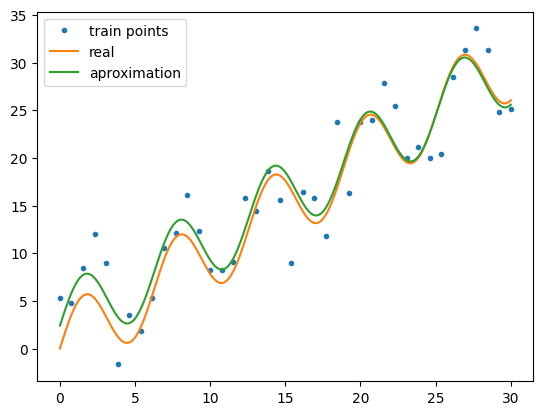

In [10]:
plt.plot(x, Y, '.', label='train points')

x_plot = np.linspace(0, 30, num=10000)
plt.plot(x_plot, 4*np.sin(x_plot) + x_plot, label='real')

X_plot = np.vstack([np.ones_like(x_plot), x_plot, np.sin(x_plot)]).T
plt.plot(x_plot, X_plot@w, label='aproximation')

plt.legend(loc='best')
plt.show()

### Модель линейной классификации, как решать оптимизационную задачу
Линейная модель бинарной (-1 и 1) классификации:
$$
\mathfrak{F}_{bcl} = \left\{f\bigr(\mathbf{w}, \mathbf{x}\bigr)=\text{sign}\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}\bigr)\bigr| \mathbf{w} \in \mathbb{R}^{n} \right\}.
$$
Требуется решить следующую оптимизационную задачу:
$$
\hat{\mathbf{w}} = \arg \min_{\mathbf{w} \in \mathbb{R}^n} \frac{1}{l}\sum_{i=1}^l\bigr[\mathbf{w}^{\mathsf{T}}\mathbf{x}_i \not= y_i\bigr] = \arg \min_{\mathbf{w} \in \mathbb{R}^n} \frac{1}{l}\sum_{i=1}^l\bigr[y_i\mathbf{w}^{\mathsf{T}}\mathbf{x}_i < 0 \bigr].
$$
Но вместо этой задачи оптимизации будем минимизировать верхнюю оценку:
$$
\hat{\mathbf{w}} = \arg \min_{\mathbf{w} \in \mathbb{R}^n} \frac{1}{l}\sum_{i=1}^l\text{log}_{2}\bigr(1+e^{-y_i\mathbf{w}^{\mathsf{T}}\mathbf{x}_i}\bigr)
$$

Но как ее минимизировать? Аналитическое решение найти не получится. Будем минизировать градиентными методами.

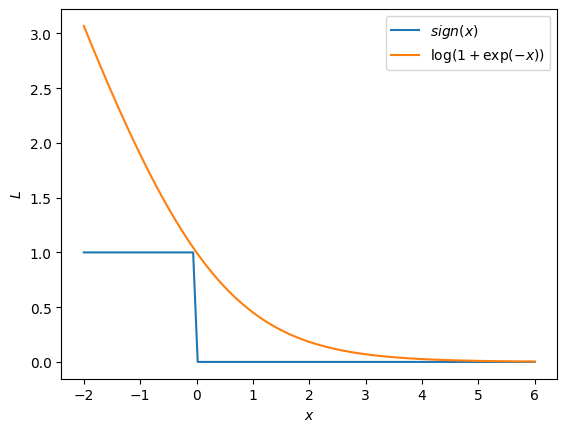

In [11]:
def sign(x):
    return np.array(x <= 0, dtype=np.int64)
def upper_bound(x):
    return np.log2(1+np.exp(-x))

x = np.linspace(-2, 6, 100)
plt.plot(x, sign(x), label='$sign(x)$')
plt.plot(x, upper_bound(x), label='$\log(1+\exp(-x))$')

plt.xlabel('$x$')
plt.ylabel('$L$')
plt.legend(loc='best')
plt.show()

### Стохастический градиентный спуск
Напомним простой градиентный спуск:
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla \mathscr{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr).
$$
В чем минусы?
1. Очень долго считать градиент суммы $\mathscr{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = \frac{1}{l}\sum_{i=1}^{l}q\bigr(\mathbf{w}, \mathbf{x}_i, y_i\bigr)$
2. Как ускорить?

Рассмотрим стохастический градиентный спуск:
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \nabla q\bigr(\mathbf{w}, \mathbf{x}_{i_k}, y_{i_k}\bigr).
$$

В случае, если индекс объекта $i_k$ сгенерирован равновероятно, то справедливо следующее свойство:
$$
\mathsf{E} \nabla q\bigr(\mathbf{w}, \mathbf{x}_{i_k}, y_{i_k}\bigr) = \frac{1}{l}\sum_{i=1}^{l}\nabla q\bigr(\mathbf{w}, \mathbf{x}_i, y_i\bigr) = \nabla\mathscr{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr),
$$
то есть получаем, что в среднем градиент на каждой итерации направлен вдоль истинного градиента.

### Анализ сходимости стохастического градиента
Рассмотрим задачу оптимизации:
$$
\mathscr{L}\bigr(\mathbf{w}\bigr) = \frac{1}{l}\sum_{i=1}^{l}q\bigr(\mathbf{w}, i\bigr) \to \min_{\mathbf{w}},
$$
где $\mathscr{L}$ является выпуклой функцией по параметру $\mathbf{w}$.

Стохастический градиентный спуск:
$$
\mathbf{w}_{k+1} = \mathbf{w}_k - \alpha_k \hat{\mathbf{g}}_k, \quad \mathsf{E}\hat{\mathbf{g}}_k = \mathbf{g}_k = \nabla\mathscr{L}\bigr(\mathbf{w}\bigr).
$$

Рассмотрим норму невязки:
$$
||\textbf{w}_{k+1} - \textbf{w}^*||^2 = ||\textbf{w}_{k}-\textbf{w}^* - \alpha_{k}\hat{\textbf{g}}_k||^2 = ||\textbf{w}_{k} - \textbf{w}^*||^2 -2\alpha_{k}\hat{\textbf{g}}_k^{\mathsf{T}}(\textbf{w}_{k} - \textbf{w}^*) + \alpha_{k}^2||\hat{\textbf{g}}_k||^2.
$$

Рассмотрим среднее значение невязки при случайном выборе $\hat{\mathbf{g}}_k$:
$$
\mathsf{E}||\textbf{w}_{k+1} - \textbf{w}^*||^2 = ||\textbf{w}_{k} - \textbf{w}^*||^2 -2\alpha_{k}\textbf{g}_k^{\mathsf{T}}(\textbf{w}_{k} - \textbf{w}^*) + \alpha_{k}^2\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$
Далее нам потребуется следующая величина:
$$
\alpha_{k}\textbf{g}_k^{\mathsf{T}}(\textbf{w}_{k} - \textbf{w}^*) = \frac{1}{2}||\textbf{w}_{k} - \textbf{w}^*||^2 - \frac{1}{2}\mathsf{E}||\textbf{w}_{k+1} - \textbf{w}^*||^2 + \frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$

В силу выпуклости функции $\mathscr{L}$ справедливо следующее свойство:
$$
\mathscr{L}\bigr(\mathbf{w}_k\bigr) - \mathscr{L}\bigr(\mathbf{w}^*\bigr) \leq\textbf{g}_k^{\mathsf{T}}(\textbf{w}_{k} - \textbf{w}^*)
$$

Откуда получаем:
$$
\alpha_k\left(\mathscr{L}\bigr(\mathbf{w}_k\bigr) - \mathscr{L}\bigr(\mathbf{w}^*\bigr)\right) \leq \frac{1}{2}||\textbf{w}_{k} - \textbf{w}^*||^2 - \frac{1}{2}\mathsf{E}||\textbf{w}_{k+1} - \textbf{w}^*||^2 + \frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$

Далее усредним уже по $\mathbf{w}_k$ для всех $k=0, \ldots,  K$ и просуммируем $K + 1$ первых итераций:
$$
\sum_{k=0}^{K}\alpha_k\left(\mathsf{E}\mathscr{L}\bigr(\mathbf{w}_k\bigr) - \mathscr{L}\bigr(\mathbf{w}^*\bigr)\right) \leq \frac{1}{2}||\mathbf{w}_0 - \mathbf{w}^*||^2 - \frac{1}{2}\mathsf{E}||\textbf{w}_{K+1} - \textbf{w}^*||^2 + \sum_{k=0}^{K}\frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2 \leq \frac{1}{2}||\mathbf{w}_0 - \mathbf{w}^*||^2 + \sum_{k=0}^{K}\frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$

Используем неравенство Йенсена для выпуклой функции $\mathscr{L}$:
$$
\mathsf{E}\mathscr{L}\left(\frac{1}{\sum\alpha_k}\sum\alpha_k\mathbf{w}_k\right) - \mathscr{L}\bigr(\mathbf{w}^*\bigr) \leq \sum_{k=0}^{K}\alpha_k\left(\mathsf{E}\mathscr{L}\bigr(\mathbf{w}_k\bigr) - \mathscr{L}\bigr(\mathbf{w}^*\bigr)\right) \leq \frac{1}{2}||\mathbf{w}_0 - \mathbf{w}^*||^2 + \sum_{k=0}^{K}\frac{\alpha_{k}^2}{2}\mathsf{E}||\hat{\textbf{g}}_k||^2.
$$

Для удобства введем обозначение и предположения:
$$
\hat{\mathbf{w}}_{K} = \frac{1}{\sum\alpha_k}\sum\alpha_k\mathbf{w}_k, \quad ||\textbf{w}_0 - \textbf{w}^*||^2 \leq R^2, \quad \mathsf{E}||\hat{\textbf{g}}_k||^2 \leq G^2.
$$

Получаем следующую оценку:
$$
\mathsf{E}\mathscr{L}\bigr(\hat{\mathbf{w}}_K\bigr) - \mathscr{L}\bigr(\mathbf{w}^*\bigr) \leq \frac{R^2+G^2\sum\alpha^2_k}{2\sum\alpha_k}
$$

Проанализируем выражение на скорость сходимости:
$$
\mathsf{E}\mathscr{L}\bigr(\mathbf{w}_K\bigr) - \mathscr{L}\bigr(\mathbf{w}^*\bigr) \leq \frac{R^2+G^2\sum\alpha^2_k}{2\sum\alpha_k}
$$

Первый способ выборка шага:
$$
\quad \sum\alpha_k = \infty, \quad \sum\alpha^2_k < \infty, \qquad \left[ \alpha_k = \frac{1}{k}\right]
$$
получаем скорость сходимости $\approx O\left(\frac{1}{\log K}\right)$.

Второй способ выбора шага:
$$
\quad \sum\alpha_k = \infty, \quad \frac{\sum\alpha^2_k}{\sum\alpha_k} = 0, \qquad \left[ \alpha_k = \frac{1}{\sqrt{k}}\right]
$$
получаем скорость сходимости $\approx O\left(\frac{\log K}{\sqrt{K}}\right)$.

Получили важное свойство, что при константном шаге метод стохастического градиента не сходится.

### Вернемся к задаче бинарной классификации
$$
\hat{\mathbf{w}} = \arg \min_{\mathbf{w} \in \mathbb{R}^n} \frac{1}{l}\sum_{i=1}^l\log_{2}\bigr(1+e^{-y_i\mathbf{w}^{\mathsf{T}}\mathbf{x}_i}\bigr)
$$

In [12]:
torch.manual_seed(0)

l = 1000
n = 2

X = torch.randn([l, n])
w_true = torch.randn([n]) # True parameters of the model
Y = torch.ones([l])
Y[X@w_true < 0] = -1

In [13]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss_sqrt = []
for k in range(1, K+1):

    # TODO матод скользящей ошибки
    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss_sqrt.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    # выбираем случайный элемент из выборки
    ind = np.random.randint(low=0, high=l)
    alpha = 1/np.sqrt(k)

    # считаем ошибку на элементе
    q = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))

    # считаем g с крышкой
    q.backward()

    # делаем градиентный шаг
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)

    # обнуляем градиент
    w.grad.zero_()

In [14]:
pred = torch.ones([l])
pred[X@w < 0] = -1
print('Точность прогноза: {}'.format(torch.mean((pred == Y).float()).item()))

Точность прогноза: 0.9980000257492065


In [15]:
torch.manual_seed(0)
np.random.seed(0)
w = torch.randn([n], requires_grad=True)

K = l
list_of_loss = []
for k in range(1, K+1):
    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss.append(torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    # выбираем случайный элемент из выборки
    ind = np.random.randint(low=0, high=l)
    alpha = 1/k

    # считаем ошибку на элементе
    q = torch.log2(1+torch.exp(-Y[ind]*(X[ind]@w)))

    # считаем g с крышкой
    q.backward()

    # делаем градиентный шаг
    with torch.no_grad():
        w.add_(w.grad, alpha=-1*alpha)

    # обнуляем градиент

    # w.grad is dq/dw

    w.grad.zero_()

In [16]:
pred = torch.ones([l])
pred[X@w < 0] = -1
print('Точность прогноза: {}'.format(torch.mean((pred == Y).float()).item()))

Точность прогноза: 0.9879999756813049


In [17]:
torch.manual_seed(0)
w = torch.randn([n], requires_grad=True)

dataset = torch.utils.data.TensorDataset(X, Y)
# Without repertition
generator = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.SGD([w], lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                              lambda k: 1/np.sqrt(k+1))

list_of_loss_torch = []
for x, y in generator:
    optimizer.zero_grad()

    # Считаем ошибку L на k-м шаге
    with torch.no_grad():
        list_of_loss_torch.append(
            torch.mean(torch.log2(1+torch.exp(-Y*(X@w)))))

    q = torch.log2(1+torch.exp(-y*(x@w))).mean()

    q.backward()

    optimizer.step()
    scheduler.step()

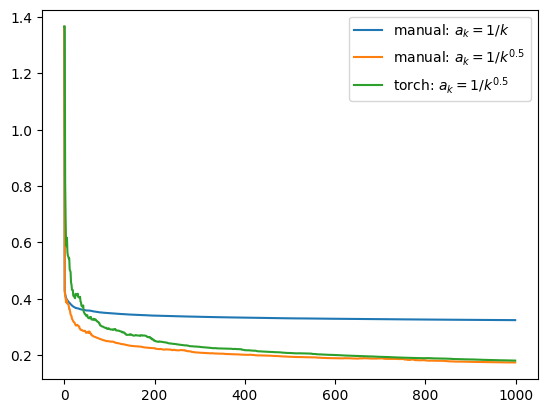

In [18]:
plt.plot(list_of_loss, label="manual: $a_k = 1/k$")
plt.plot(list_of_loss_sqrt, label="manual: $a_k = 1/k^{0.5}$")
plt.plot(list_of_loss_torch, label="torch: $a_k = 1/k^{0.5}$")
plt.legend(loc='best')
plt.show()

## Вероятностная постановка задачи машинного обучения

### Линейная регрессия
Рассмотрим следующее вероятностное предположение о данных:
$$
y = \mathbf{w}^{\mathsf{T}}\mathbf{x} + \varepsilon, \quad \varepsilon \sim \mathscr{N}\bigr(0, \beta\bigr)
$$

Пусть векторы $\mathbf{w}$ и $\mathbf{x}$ являются неслучайными, тогда получаем, что $y$ является нормальной случайной величиной. Пусть все объекты выборки также являются независимыми случайными величинами, тогда получаем правдоподобие выборки:
$$
p\bigr(\mathbf{y}|\mathbf{w}, \mathbf{X}\bigr) = \prod_{i=1}^{l}p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr),
$$
где $p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr)=\mathscr{N}\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i, \beta)$.

Принцип максимума правдоподобия:
$$
\mathscr{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) = \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C\right]
$$

Данная задача эквивалентна задаче, которая была рассмотрена в начале для линейной регрессии. Решение задачи имеет вид:
$$
\hat{\mathbf{w}} = \left(\mathbf{X}^{\mathsf{T}}\mathbf{X}\right)^{-1}\mathbf{X}^{\mathsf{T}}\mathbf{y}
$$

TODO: Вопрос почему beta/2

Теперь рассмотрим совместное правдоподобие модели и данных:
$$
p\bigr(\mathbf{y}, \mathbf{w}|\mathbf{X}\bigr) = \prod_{i=1}^{l}p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr)p\bigr(\mathbf{w}\bigr),
$$
где для простоты рассмотрим $p\bigr(\mathbf{w}\bigr)=\mathscr{N}\bigr(\mathbf{0}, \gamma\mathbf{I})$.

По принципу максимума правдоподобия получаем следующую функцию для минимизации:
$$
\mathscr{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr) = \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C_1\right] + \mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2.
$$

Заметим, что следующая задача оптимизации имеет аналитическое решение:
$$
\hat{\mathbf{w}} = \arg\min_{\mathbf{w} \in \mathbb{R}^{n}} \left\{-\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr)\right\} = \arg\min_{\mathbf{w} \in \mathbb{R}^{n}} \left\{ \sum_{i=1}^{l}\left[\frac{\beta}{2}\left(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i-y_i\right)^2 + C_1\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2 \right\}.
$$

### Логистическая регрессия
Рассмотрим следующее вероятностное предположение о данных:
$$
y \sim \text{Be}\bigr(\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}\bigr)\bigr), \quad \sigma\bigr(x\bigr) = \frac{1}{1+\exp\bigr(-x\bigr)}.
$$

Принцип максимума правдоподобия:
$$
\mathscr{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) = \sum_{i=1}^{l}\left[y_i\log\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr) + \left(1-y_i\right)\log\left(1-\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr)\right) + C\right].
$$

Аналогично рассмотрим совместное правдоподобие модели и данных. Запишем правдоподобие в случае, когда $p\bigr(\mathbf{w}\bigr)=\mathscr{N}\bigr(\mathbf{0}, \gamma\mathbf{I})$:
$$
\mathscr{L}\bigr(\mathbf{w}, \mathbf{X}, \mathbf{y}\bigr) = -\sum_{i=1}^{l}\log p\bigr(y_i|\mathbf{w}, \mathbf{x}_i\bigr) - \log p\bigr(\mathbf{w}\bigr) = \sum_{i=1}^{l}\left[y_i\log\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr) + \left(1-y_i\right)\log\left(1-\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr)\right) + C_1\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w} + C_2.
$$

## Анализ решения задачи оптимизации от параметра $\gamma$
Заметим, что решение оптимизационной задачи зависит от параметра $\gamma$:
$$
\hat{\mathbf{w}}\bigr(\gamma\bigr) = \arg\min_{\mathbf{w} \in \mathbb{R}^{n}} \left\{\sum_{i=1}^{l}\left[y_i\log\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr) + \left(1-y_i\right)\log\left(1-\sigma\bigr(\mathbf{w}^{\mathsf{T}}\mathbf{x}_i\bigr)\right)\right] + \frac{\gamma}{2}\mathbf{w}^{\mathsf{T}}\mathbf{w}\right\}.
$$

Рассмотрим решение логистической регрессии для разных параметров $\gamma$.

In [37]:
np.random.seed(0)
l = 50000
n = 2

X = np.random.randn(l, n)
w = np.random.randn(n)
Y = np.random.binomial(n=1, p=expit(X@w)) # sigmoid

In [38]:
gammas = [1e-10, 1e-4, 1e-3, 1e-2, .1, 1., 10., 1e2, 1e3, 1e4, 1e10]

models_l2 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l2', C=2/gamma, fit_intercept=False,
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l2[gamma] = model

models_l1 = dict()
for gamma in gammas:
    model = LogisticRegression(penalty='l1', C=2/gamma, fit_intercept=False,
                               random_state=0, solver='saga')
    model.fit(X, Y)
    models_l1[gamma] = model

## Homework analytical solution

In [55]:
w_prime = np.linalg.inv(X.T@X + 10)@X.T@Y

In [56]:
w_prime

array([-0.09198385,  0.24005653])

In [47]:
models_l2

{1e-10: LogisticRegression(C=20000000000.0, fit_intercept=False, random_state=0,
                    solver='saga'),
 0.0001: LogisticRegression(C=20000.0, fit_intercept=False, random_state=0,
                    solver='saga'),
 0.001: LogisticRegression(C=2000.0, fit_intercept=False, random_state=0, solver='saga'),
 0.01: LogisticRegression(C=200.0, fit_intercept=False, random_state=0, solver='saga'),
 0.1: LogisticRegression(C=20.0, fit_intercept=False, random_state=0, solver='saga'),
 1.0: LogisticRegression(C=2.0, fit_intercept=False, random_state=0, solver='saga'),
 10.0: LogisticRegression(C=0.2, fit_intercept=False, random_state=0, solver='saga'),
 100.0: LogisticRegression(C=0.02, fit_intercept=False, random_state=0, solver='saga'),
 1000.0: LogisticRegression(C=0.002, fit_intercept=False, random_state=0, solver='saga'),
 10000.0: LogisticRegression(C=0.0002, fit_intercept=False, random_state=0, solver='saga'),
 10000000000.0: LogisticRegression(C=2e-10, fit_intercept=False, r

## Plots

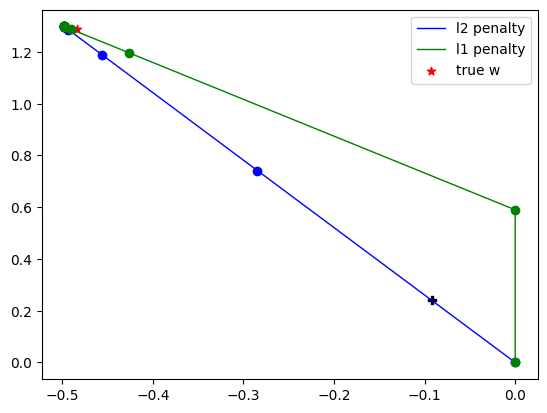

In [57]:
x = [models_l2[gamma].coef_[0][0] for gamma in models_l2]
y = [models_l2[gamma].coef_[0][1] for gamma in models_l2]

plt.plot(x, y, 'bo')
plt.plot(x, y, 'b-', linewidth=1, label='l2 penalty')

x = [models_l1[gamma].coef_[0][0] for gamma in models_l1]
y = [models_l1[gamma].coef_[0][1] for gamma in models_l1]

plt.plot(x, y, 'go')
plt.plot(x, y, 'g-', linewidth=1, label='l1 penalty')

plt.scatter(w[0], w[1], marker='*', c='r', label='true w')
plt.legend(loc='best')
# plt.show()

plt.scatter(w_prime[0], w_prime[1], marker='P', c='black', label='analytical w')
# plt.legend(loc='best')
plt.show()

### Как находить оптимальное $\gamma$

### LOO

Одним из простых методов борьбы с переобучением является метод Leave One Out. Для удобства обозначим $\hat{\theta}\bigr(\mathbf{X}\bigr)$ как оптимальный вектор для выборки $\mathbf{X}$. Тогда ошибка LOO определяется следующим образом:
$$LOO\bigr(\mu, \textbf{X}_{tr}, \textbf{y}_{tr}, \textbf{X}_{vl}, \textbf{y}_{vl}\bigr) =
\sum_{i=1}^{l_{tr}+l_{vl}}q\bigr(\hat{\theta}\bigr(\mathbf{X}_{tr}\cup\textbf{X}_{vl}\setminus\mathbf{x}_i, \mu\bigr), \mathbf{x}_i, y_i\bigr),$$
где $\mathbf{x}_i$ - это элемент из объединенного датасета обучения и валидации.

После чего оптимальный вектор параметров является решением следующей оптимизационной задачи:
$$
\hat{\mu} = \arg\min_{\mu \in \mathfrak{M}} LOO\bigr(\mu, \textbf{X}_{tr}, \textbf{y}_{tr}, \textbf{X}_{vl}, \textbf{y}_{vl}\bigr),
$$
$$
\hat{\theta} = \hat{\theta}\bigr(\mathbf{X}_{tr}\cup\textbf{X}_{vl}, \hat{\mu}\bigr)
$$

Для поиска оптимального $\gamma$ вспомним про Cross Validation и LOO методы.

LOO:
$$
\hat{\gamma} = \arg\min_{\gamma \in \Gamma} LOO\bigr(\gamma, \textbf{X}_{tr}, \textbf{y}_{tr}, \textbf{X}_{vl}, \textbf{y}_{vl}\bigr), \quad LOO\bigr(\mu, \textbf{X}_{tr}, \textbf{y}_{tr}, \textbf{X}_{vl}, \textbf{y}_{vl}\bigr) =
\sum_{i=1}^{l_{tr}+l_{vl}}q\bigr(\hat{\mathbf{w}}\bigr(\gamma\bigr), \mathbf{x}_i, y_i\bigr),
$$

На лекции рассмотрим метод LOO. В Cross Validation все то же самое, но откладываем не по одному элементу, а больше.

In [26]:
np.random.seed(0)
l = 1000
n = 2

X_train = np.random.randn(l, n)
X_test = np.random.randn(500, n)
w = np.random.randn(n)
Y_train = np.random.binomial(n=1, p=expit(X_train@w))
Y_test = np.random.binomial(n=1, p=expit(X_test@w))

In [23]:
loo = LeaveOneOut()
number_of_batch = loo.get_n_splits(X_train)

gamma_scores = dict()
for gamma in tqdm(gammas):
    list_of_scores = []
    for train_index, test_index in tqdm(loo.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = LogisticRegression(penalty='l2', C=2/gamma, solver='saga',
                                   fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    gamma_scores[gamma] = np.mean(list_of_scores)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [27]:
gamma_scores

{1e-10: np.float64(0.777),
 0.0001: np.float64(0.777),
 0.001: np.float64(0.777),
 0.01: np.float64(0.777),
 0.1: np.float64(0.777),
 1.0: np.float64(0.777),
 10.0: np.float64(0.776),
 100.0: np.float64(0.776),
 1000.0: np.float64(0.777),
 10000.0: np.float64(0.777),
 10000000000.0: np.float64(0.777)}

In [24]:
best_gamma = sorted(gamma_scores,
                    key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty='l2', C=2/best_gamma, fit_intercept=False,
                           random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.768


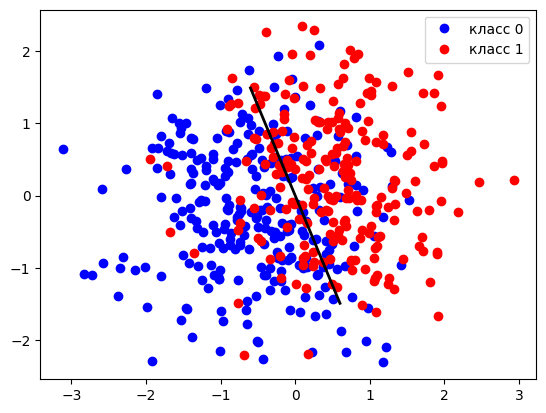

In [29]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o',
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6),
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()

# Домашнее задание:

Используя вероятностную постановку задачи для линейной регрессии с априорным предположением p(w) = N(0, I) получить аналитическое решение на оптимальный вектор параметров w.

Использовать метод Cross-Validation вместо метода LOO для выбора оптимального параметра регуляризации gamma.


In [61]:
loo = KFold(n_splits = 2)
number_of_batch = loo.get_n_splits(X_train)
print(number_of_batch)

gamma_scores = dict()
for gamma in tqdm(gammas):
    list_of_scores = []
    for train_index, test_index in tqdm(loo.split(X_train),
                                        total=number_of_batch, leave=False):
        x_train, x_test = X_train[train_index], X_train[test_index]
        y_train, y_test = Y_train[train_index], Y_train[test_index]

        model = LogisticRegression(penalty='l2', C=2/gamma, solver='saga',
                                   fit_intercept=False, random_state=0)
        model.fit(x_train, y_train)
        list_of_scores.append(model.score(x_test, y_test))

    gamma_scores[gamma] = np.mean(list_of_scores)

2


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [62]:
best_gamma = sorted(gamma_scores,
                    key=lambda x: gamma_scores[x], reverse=True)[0]

model = LogisticRegression(penalty='l2', C=2/best_gamma, fit_intercept=False,
                           random_state=0, solver='saga')
model.fit(X_train, Y_train)
print('Точность: {}'.format(model.score(X_test, Y_test)))

Точность: 0.77


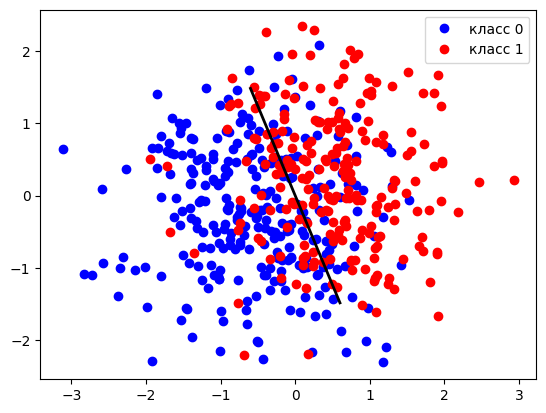

In [63]:
cols = ['blue', 'red']

for k in np.unique(Y_test):
    plt.plot(X_test[Y_test==k,0], X_test[Y_test==k,1], 'o',
             label='класс {}'.format(k), color=cols[k])

plt.plot(*get_line(*model.coef_[0], x_min=-0.6, x_max=0.6),
         linewidth=2, color='black')

plt.legend(loc='best')
plt.show()